<figure>
<IMG SRC="../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 6

### Error bounds on coherence estimates

<div style='background:#F0F0F0'>  The 95% confidence intervals for the coherence squared $\gamma^2_{xy}(f)$ between two variables $x(t)$ and $y(t)$ are approximately:
$$ \gamma^2_{xy} \pm \frac{\sqrt{2}\left(1+\gamma^2_{xy}\right)}{\left|\gamma_{xy} \right|\sqrt{n_d}}$$
where $n_d$ is the number of blocks used to calculate the coherence.  

You **may** use `matplotlib.mlab.csd` for the following question, but you had best use it correctly!
</div>

<div style='background:#F0F0F0'>**1** Make an input process $x(t)$ as random Gaussian noise, and the output process the sum of a noise source and a running average of the input: $y(t)=n(t)+\frac{1}{b}\int_{t-b}^t x(t')dt'$ and plot (Zoom so we can see whats going on, and label your plot).  Make sure you generate a large time series.</div> 

In [2]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib nbagg
%matplotlib inline

Note that the x(t) and y(t) have 65536 data points from 0 to 65536, 
but the plots have been zoomed in to display 0<t<100 for clearity.


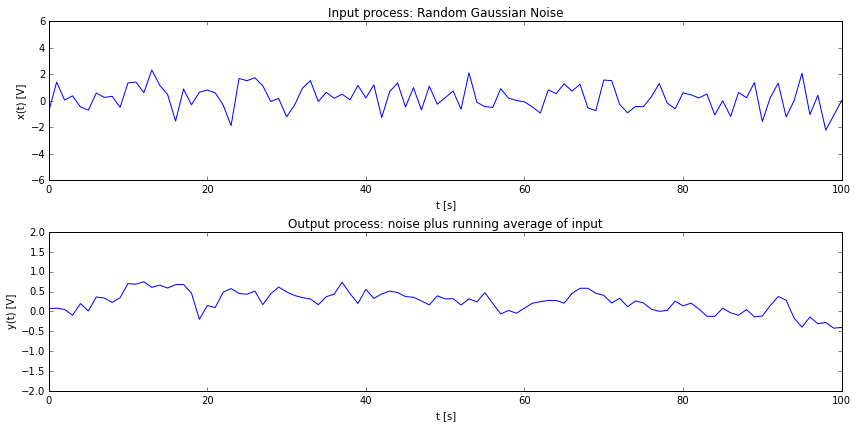

In [3]:
# Make input process x(t) random gaussian noise
def makeInput(N):
    t = np.arange(N)
    x = np.random.normal(0,1,N)
        
    return t,x
    
# Take the moving average (Credit to heltonboker @ StackOverFlow.com)
def movingaverage(interval, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# Make output process y(t) the sum of a noise source and running average of the input
def makeOutput(t,x):
    y = movingaverage(x,10)
    n = np.random.normal(0,0.1,len(y))
    y += n
    
    return y

# plot it
def plotData(t,x,y,xlim):
    plt.figure(figsize=(12,6))
    gs=gridspec.GridSpec(2,1)

    ax1=plt.subplot(gs[0:1])
    ax1.plot(t,x)
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel('x(t) [V]')
    ax1.set_title('Input process: Random Gaussian Noise')
    ax1.set_xlim(right=xlim)

    ax2=plt.subplot(gs[1:2])
    ax2.plot(t,y)
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('y(t) [V]')
    ax2.set_title('Output process: noise plus running average of input')
    ax2.set_xlim(right=xlim)
    
    plt.tight_layout()
    
# Run the functions
N = 2**16
xlim = 100
t,x = makeInput(N)
y = makeOutput(t,x)
plotData(t,x,y,xlim)

print 'Note that the x(t) and y(t) have %d data points from 0 to %d, \nbut the plots have been zoomed in to display 0<t<%d for clearity.' %(N,N,xlim) 

<div style='background:#F0F0F0'>**2** Compute the coherence squared of the input and the output.  Make a plot with the spectra in the upper panel and the coherence squared in the middle panel and the phase in the bottom.

You will need to choose a value for your fft length.  Choose a relative low one to get a smooth plot.
</div>

C:\Anaconda\lib\site-packages\numpy\core\numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(<matplotlib.axes._subplots.AxesSubplot at 0xa38c978>,
 <matplotlib.axes._subplots.AxesSubplot at 0xc02ee48>)

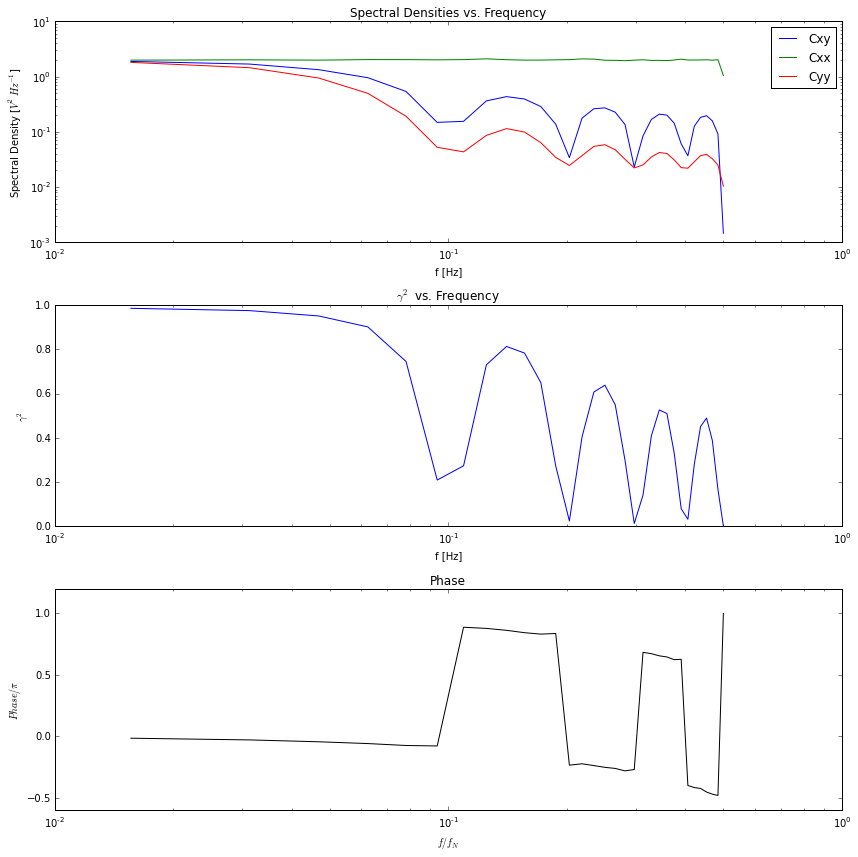

In [4]:
# Compute coherence squared
def co2(t,x,y,nfft):
    
    # Change in time between data points
    dt = t[1] - t[0]
    
    # Cross spectral densities
    Cxy,f = mlab.csd(x,y,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nfft/2)
    Cxx,f = mlab.csd(x,x,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nfft/2)
    Cyy,f = mlab.csd(y,y,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nfft/2)
    
    # Coherence squared
    gamma = np.abs(Cxy)**2/Cxx/Cyy
    
    # Number of blocks used
    nd = np.ceil(len(t)/nfft) + np.ceil(len(t)/nfft) -1
    
    return gamma,f,Cxy,Cxx,Cyy,nd

def plotCo2(gamma,f,Cxy,Cxx,Cyy,PlotPhase=True,PlotCross=True,label1='Cxx',label2='Cyy'):
    plt.figure(figsize=(12,12))
    gs=gridspec.GridSpec(3,1)

    # Upper panel: spectra
    ax1=plt.subplot(gs[0:1])
    
    if PlotCross:
        ax1.plot(f,np.abs(Cxy),label='Cxy')
    ax1.plot(f,Cxx,label=label1)
    ax1.plot(f,Cyy,label=label2)
    ax1.set_xlabel('f [Hz]')
    ax1.set_ylabel('Spectral Density [$V^2 Hz^{-1}$]')
    ax1.set_title('Spectral Densities vs. Frequency')
    ax1.legend()
    ax1.loglog()
    
    # Middle panel: coherence squared
    ax2=plt.subplot(gs[1:2])
    ax2.plot(f,gamma)
    ax2.set_xlabel('f [Hz]')
    ax2.set_ylabel(r'$\gamma^2$')
    ax2.set_title(r'$\gamma^2$ vs. Frequency')
    ax2.semilogx()
    
    if PlotPhase:
        # Bottom panel: phase
        angle = np.angle(Cxy)
        ax3=plt.subplot(gs[2:3])
        ax3.plot(f,angle/np.pi,'k')
        ax3.set_xlabel('$f / f_N$')
        ax3.set_ylabel('$Phase / \pi$')
        ax3.set_title('Phase')
        ax3.semilogx()
    
    plt.tight_layout()
    
    return ax1,ax2
    

# Run the functions
nfft = 2**6
gamma,f,Cxy,Cxx,Cyy,nd = co2(t,x,y,nfft)
plotCo2(gamma,f,Cxy,Cxx,Cyy)

Comment:

In the Spectral Densities vs. Frequency plot, X has a near constant spectral density, whereas Y has a log-periodic spectral density, as does the cross spectral density of X and Y. The coherence squared is log-periodic as well. The phase is nearly a square wave, alternating between 0 and 1 meaning the coherence squared is always either 0 or 1 depending on the frequencies, without occupying many phase/pi values inbetween.


<div style='background:#F0F0F0'>**3** Now repeat the above for three different values of NFFT, each 5 times as large as the next.  Plot the resulting coherence squared functions in separate panels.  Add the confidence intervals to your plot and comment on which peaks are significant.
</div>

(51L,)
(51L,)


C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:4391: ComplexWarning: Casting complex values to real discards the imaginary part
  X[0] = start
C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:4392: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 1] = end
C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:4395: ComplexWarning: Casting complex values to real discards the imaginary part
  X[1:N + 1, 1] = y1slice
C:\Anaconda\lib\site-packages\matplotlib\axes\_axes.py:4397: ComplexWarning: Casting complex values to real discards the imaginary part
  X[N + 2:, 1] = y2slice[::-1]


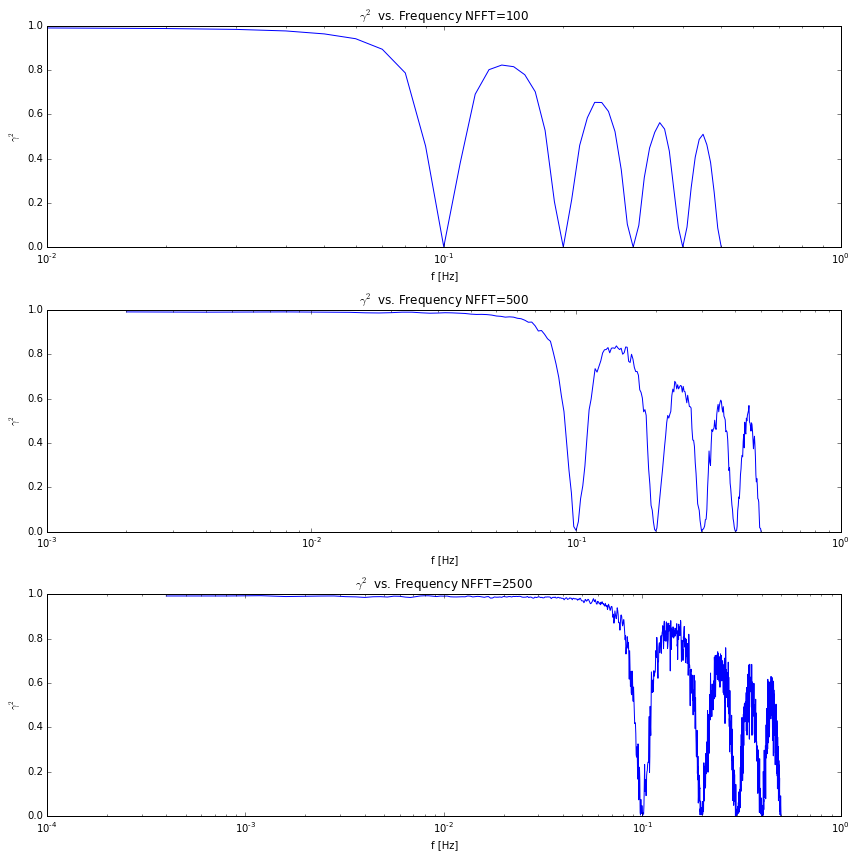

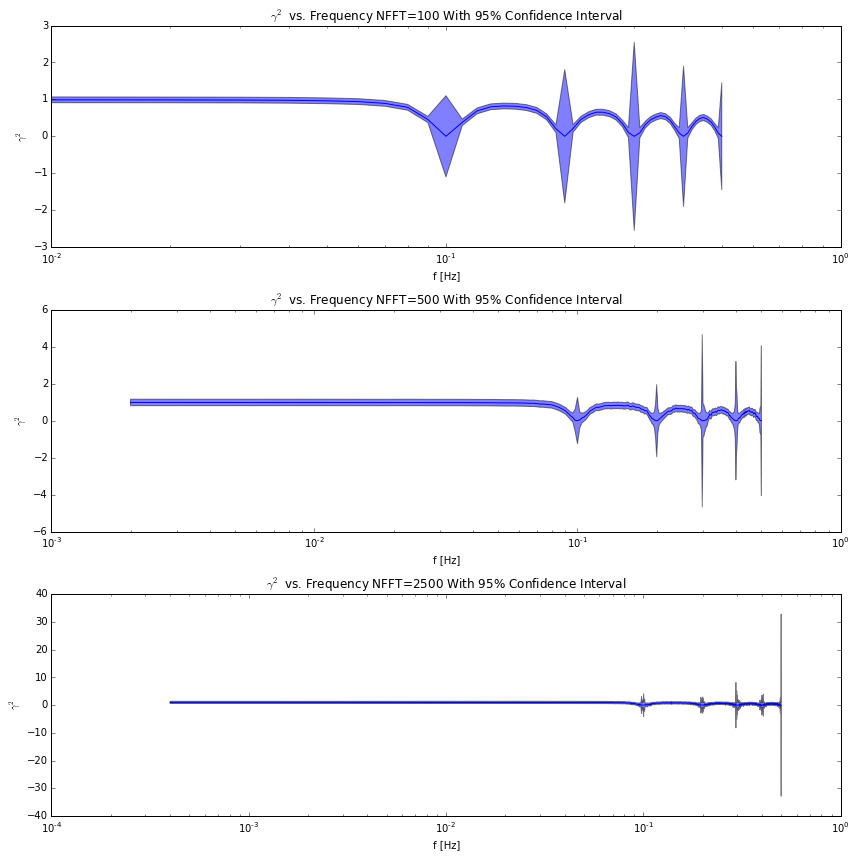

In [5]:
def confidenceInterval(g,nd):
    numerator = np.sqrt(2) * (1 + g)
    denominator = np.abs(np.sqrt(g)) * np.sqrt(nd) 
    
    bound = np.abs(numerator/denominator)
    
    upper = g + bound
    lower = g - bound
    
    return upper,lower

def plotThree(nffts,fs,Gs,nds,PlotConfidence=False):
    
    # Calculate the 95% confidence intervals
    g1_upper,g1_lower = confidenceInterval(Gs[0],nds[0])
    g2_upper,g2_lower = confidenceInterval(Gs[1],nds[1])
    g3_upper,g3_lower = confidenceInterval(Gs[2],nds[2])
    
    # Do the plotting
    plt.figure(figsize=(12,12))
    gs=gridspec.GridSpec(3,1)
    
    ax1=plt.subplot(gs[0:1])
    ax1.plot(fs[0],Gs[0])
    if PlotConfidence:
        ax1.fill_between(fs[0],g1_lower,g1_upper,alpha=0.5) # 95% Confidence Interval
    ax1.set_xlabel('f [Hz]')
    ax1.set_ylabel(r'$\gamma^2$')
    ax1.set_title(r'$\gamma^2$ vs. Frequency NFFT=%d'%nffts[0])
    ax1.semilogx()
    
    ax2=plt.subplot(gs[1:2])
    ax2.plot(fs[1],Gs[1])
    if PlotConfidence:
        ax2.fill_between(fs[1],g2_lower,g2_upper,alpha=0.5) # 95% Confidence Interval
    ax2.set_xlabel('f [Hz]')
    ax2.set_ylabel(r'$\gamma^2$')
    ax2.set_title(r'$\gamma^2$ vs. Frequency NFFT=%d'%nffts[1])
    ax2.semilogx()
    
    ax3=plt.subplot(gs[2:3])
    ax3.plot(fs[2],Gs[2])
    if PlotConfidence:
        ax3.fill_between(fs[2],g3_lower,g3_upper,alpha=0.5) # 95% Confidence Interval
    ax3.set_xlabel('f [Hz]')
    ax3.set_ylabel(r'$\gamma^2$')
    ax3.set_title(r'$\gamma^2$ vs. Frequency NFFT=%d'%nffts[2])
    ax3.semilogx()
    
    plt.tight_layout()
    return ax1,ax2,ax3
    
# Run the functions
n1=100
nffts=[n1,n1*5,n1*5*5]

g1,f1,Cxy,Cxx,Cyy,nd1 = co2(t,x,y,nffts[0])
g2,f2,Cxy,Cxx,Cyy,nd2 = co2(t,x,y,nffts[1])
g3,f3,Cxy,Cxx,Cyy,nd3 = co2(t,x,y,nffts[2])

fs=[f1,f2,f3]
gs=[g1,g2,g3]
nds=[nd1,nd2,nd3]

print fs[0].shape
print gs[0].shape

plotThree(nffts,fs,gs,nds)
ax1,ax2,ax3 = plotThree(nffts,fs,gs,nds,PlotConfidence=True)
ax1.set_title(r'$\gamma^2$ vs. Frequency NFFT=%d'%nffts[0] + ' With 95% Confidence Interval')
ax2.set_title(r'$\gamma^2$ vs. Frequency NFFT=%d'%nffts[1] + ' With 95% Confidence Interval')
ax3.set_title(r'$\gamma^2$ vs. Frequency NFFT=%d'%nffts[2] + ' With 95% Confidence Interval')

Comment:

For the plots without intervals, we see that larger values of NFFT contain more noise than the lower NFFT values. This is expected, as lower NFFT values take averages over more more sets of data than the larger values do. (The data is divided more times for smaller NFFT).

The 95% confidence intervals shown in the plots above show us that we are very confident about our coherence squared results when the coherence squared is closer to 1 than to 0, but we are not very confident at all when the coherence squared sinks near zero as it does (for example) at 0.1 Hz for each value of NFFT. 

## Q2: Shear turbulence data

In [6]:
time=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/time.txt')
ac=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/ac.txt')
shear=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/s.txt')

# Finding dt for use in part 4
print 'dt = ',time[1]-time[0]
print 'dt = ',time[100]-time[99]

dt =  0.0064
dt =  0.0064



<div style='background:#F0F0F0'>Download the data abaove. `time` is a measurement time in seconds. `shear` is a little less than 300 s of data from a turbulence shear probe. Units are $s^{-1}$. `ac` is a suitably scaled acceleration of the vehicle containing the shear probes.

**1** Plot the shear time series and the accelerometer time series.  Comment on any similarities and differences.  Comment on the stationarity of the time series.

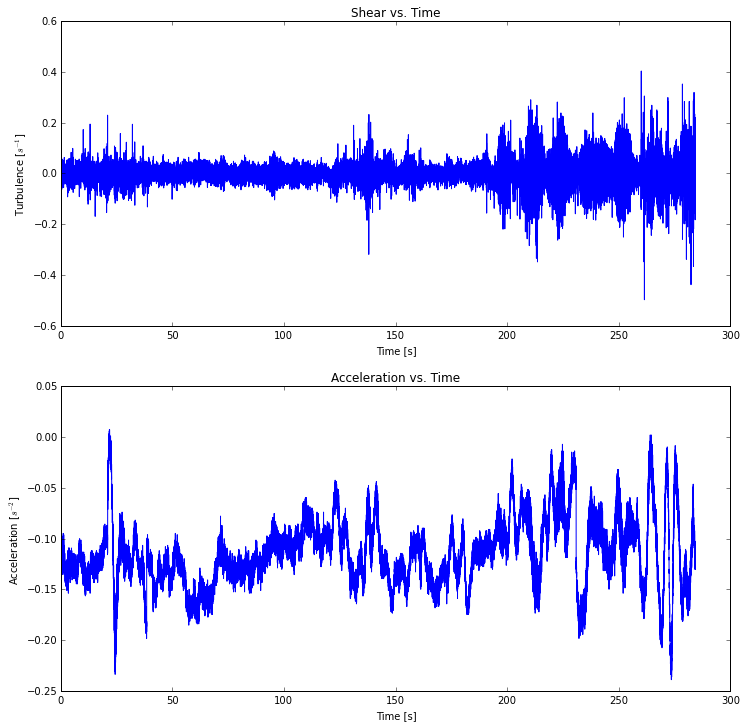

In [7]:
def plotTimeSeries(time,shear,ac):
    plt.figure(figsize=(12,12))
    gs=gridspec.GridSpec(2,1)
    
    ax1=plt.subplot(gs[0:1])
    ax1.plot(time,shear)
    #ax1.plot(time,ac)
    ax1.set_xlabel('Time [s]')
    ax1.set_ylabel(r'Turbulence [$s^{-1}$]')
    ax1.set_title('Shear vs. Time')
    
    ax2=plt.subplot(gs[1:2])
    ax2.plot(time,ac)
    ax2.set_xlabel('Time [s]')
    ax2.set_ylabel('Acceleration [$s^{-2}$]')
    ax2.set_title('Acceleration vs. Time')
    
    
plotTimeSeries(time,shear,ac)
    

The Acceleration vs. Time plot is similar to the Shear vs. Time plot in that it peaks at the same times: 25s, 130s, and a lot of peaks at the end between 200s and 290s. A difference in the plots is that the Acceleration seems to have a periodic component, whereas the Shear data comes in bursts of positive and negative turbulence with (albeit noisy) zero turbulence in between.

<div style='background:#F0F0F0'> **2** Compute the power spectra of the two signals and the coherence squared (you could do the phase too, but it is not too thrilling).  Comment on the spectral similarities and the coherence.  

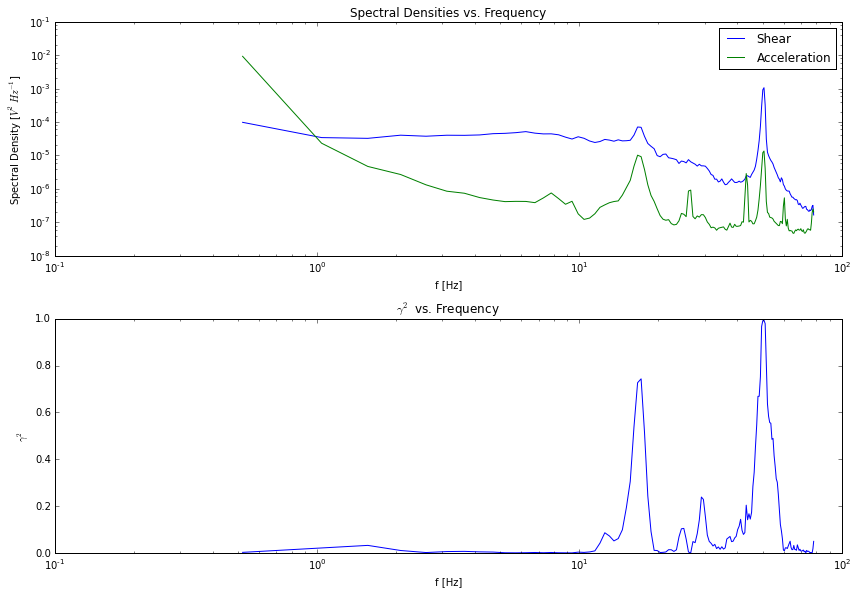

In [8]:
coherence_squared, freq, powShearAc, powShear, powAc, numBlocks = co2(time,shear,ac,300)
ax1,ax2 = plotCo2(coherence_squared, freq, powShearAc, powShear, powAc, PlotPhase=False, PlotCross=False, label1='Shear', label2='Acceleration')

The two largest peaks in the shear and acceleration spectral densities occur for the same frequencies: just before 11Hz, and at 14Hz. The acceleration spectra has more peaks than the shear spectra, which we would expect from viewing the raw data in the previous stage of the question - it seemed to have a periodic trend when the shear data did not, which makes for at least one addded frequency peak. Also, the acceleration spectra has very high energy for very small frequencies ( < 1 Hz ) but then decreases at 1 Hz until its first peak, while the shear spectra remains high until the first peak.

As is expected, the coherence is greatest when the peaks of the spectra allign: at just before 11Hz and agt 14Hz. However, there is another (smaller) peak around 12Hz which can be attributed to the fact that the shear spectral density remains high and steady while the acceleration spectral density is low until it peaks - therefore, when the acceleration spectral density peaks, the shear spectral density is also high, and coherence is seen.


<div style='background:#F0F0F0'> **3** Compute a spectra that has the contamination from the vibration removed. Comment on how well your correction worked.

[]

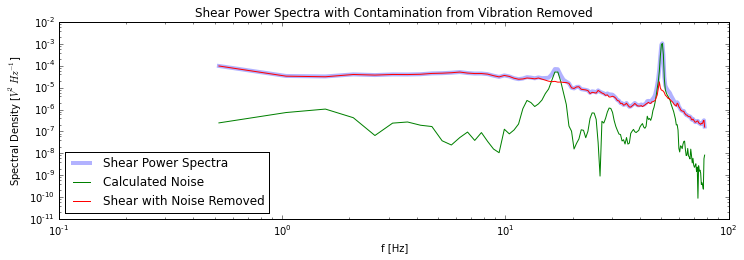

In [9]:
def removeNoise(powShear,powAc,powShearAc):
    noise = np.abs(powShearAc)**2/powAc
    shear_noNoise = powShear - np.abs(powShearAc)**2/powAc
    return noise,shear_noNoise

noise,shear_noNoise = removeNoise(powShear,powAc,powShearAc)

plt.figure(figsize=(12,12))
gs=gridspec.GridSpec(3,1)

ax1=plt.subplot(gs[0:1])
ax1.plot(freq,powShear,label='Shear Power Spectra',alpha=0.3,linewidth=4)
ax1.plot(freq,noise,label='Calculated Noise')
ax1.plot(freq,shear_noNoise,label='Shear with Noise Removed')
ax1.set_xlabel('f [Hz]')
ax1.set_ylabel('Spectral Density [$V^2 Hz^{-1}$]')
ax1.set_title('Shear Power Spectra with Contamination from Vibration Removed')
ax1.legend(loc=3)
ax1.loglog()

This correction worked fairly well. The Shear spectral density with the noise removed contains one remaining peak, at around 14 Hz which is the frequency of the highest peak for both Shear and Acceleration densities. We can expect removing this peak would be difficult as the cross spectral coherence is so high here, so we are pleased with our results.

<div style='background:#F0F0F0'>**4** Chose two separate periods of the time series, one that is "turbulent" and one that is "quiet", and plot the raw and corrected shear spectra.  Comment on the differences and the effect of the correction on each spectral estimate.    

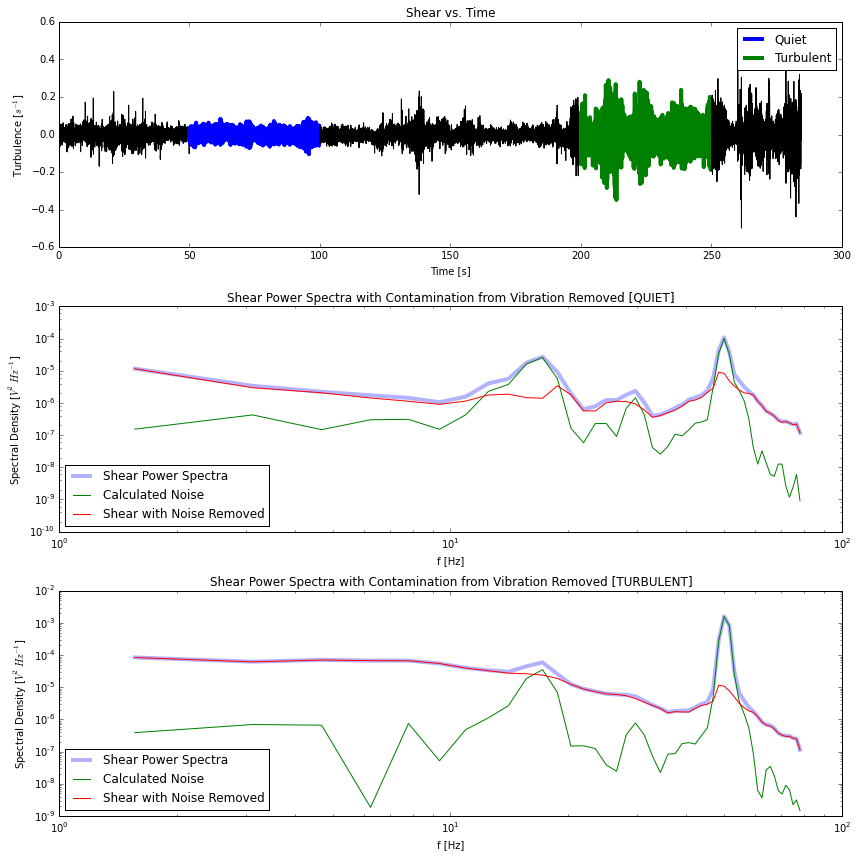

In [12]:
# Choose quiet period from 50s to 100s
dt = time[1]-time[0]
indexStart = int(50./dt)
indexStop = int(100./dt)
quietShear = shear[indexStart:indexStop]
quietTime = time[indexStart:indexStop]
quietAc = ac[indexStart:indexStop]

# Choose turbulent period from 200s to 250s
indexStart = int(200./dt)
indexStop = int(250./dt)
turbulentShear = shear[indexStart:indexStop]
turbulentTime = time[indexStart:indexStop]
turbulentAc = ac[indexStart:indexStop]

# Gather the remaining time series
other1Shear = shear[0:int(50./dt)]
other1Time = time[0:int(50./dt)]
other2Shear = shear[int(100./dt):int(200./dt)]
other2Time = time[int(100./dt):int(200./dt)]
other3Shear = shear[int(250./dt):]
other3Time = time[int(250./dt):]

# Plot the periods
plt.figure(figsize=(12,12))
gs=gridspec.GridSpec(3,1)
ax1=plt.subplot(gs[0:1])
ax1.plot(other1Time,other1Shear,'k')
ax1.plot(quietTime,quietShear,label='Quiet',linewidth=4)
ax1.plot(other2Time,other2Shear,'k')
ax1.plot(turbulentTime,turbulentShear,label='Turbulent',linewidth=4)
ax1.plot(other3Time,other3Shear,'k')
ax1.set_xlabel('Time [s]')
ax1.set_ylabel(r'Turbulence [$s^{-1}$]')
ax1.set_title('Shear vs. Time')
ax1.legend()

# Compute the coherences
co2Quiet, freqQuiet, powShearAcQuiet, powShearQuiet, powAcQuiet, numBlocksQuiet = co2(quietTime,quietShear,quietAc,100)
co2Turb, freqTurb, powShearAcTurb, powShearTurb, powAcTurb, numBlocksTurb = co2(turbulentTime,turbulentShear,turbulentAc,100)

# Compute the noise and differences
noiseQuiet,shearNoNoiseQuiet = removeNoise(powShearQuiet,powAcQuiet,powShearAcQuiet)
noiseTurb,shearNoNoiseTurb = removeNoise(powShearTurb,powAcTurb,powShearAcTurb)

# Plot the results
ax2=plt.subplot(gs[1:2])
ax2.plot(freqQuiet,powShearQuiet,label='Shear Power Spectra',alpha=0.3,linewidth=4)
ax2.plot(freqQuiet,noiseQuiet,label='Calculated Noise')
ax2.plot(freqQuiet,shearNoNoiseQuiet,label='Shear with Noise Removed')
ax2.set_xlabel('f [Hz]')
ax2.set_ylabel('Spectral Density [$V^2 Hz^{-1}$]')
ax2.set_title('Shear Power Spectra with Contamination from Vibration Removed [QUIET]')
ax2.loglog()
ax2.legend(loc=3)

ax3=plt.subplot(gs[2:3])
ax3.plot(freqTurb,powShearTurb,label='Shear Power Spectra',alpha=0.3,linewidth=4)
ax3.plot(freqTurb,noiseTurb,label='Calculated Noise')
ax3.plot(freqTurb,shearNoNoiseTurb,label='Shear with Noise Removed')
ax3.set_xlabel('f [Hz]')
ax3.set_ylabel('Spectral Density [$V^2 Hz^{-1}$]')
ax3.set_title('Shear Power Spectra with Contamination from Vibration Removed [TURBULENT]')
ax3.loglog()
ax3.legend(loc=3)

plt.tight_layout()

COMMENT:

The turbulent period has had better success with removing the noise than the quiet period. I think this is because the turbulent period has more noise, so removing it from the data was more effective. However, as we do not know the noise exactly and are using a calculation which was proven in the lecture notes to be close to correct, we can only estimate here which is better.